In [1]:
import math

In [2]:
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from data import load_train_data, load_test_data

Using TensorFlow backend.


In [4]:
img_rows = 96
img_cols = 96

smooth = 1.

In [5]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [8]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [9]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()

------------------------------
Loading and preprocessing train data...
------------------------------


In [10]:
imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)

/notebooks/lib/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [11]:
imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

In [12]:
imgs_train -= mean
imgs_train /= std

imgs_mask_train = imgs_mask_train.astype('float32')
imgs_mask_train /= 255.  # scale masks to [0, 1]

In [13]:
print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model_dir = os.environ['TRAINING_DIR']+os.sep
model = get_unet()
model_checkpoint = ModelCheckpoint(model_dir+'weights.h5', monitor='val_loss', save_best_only=True)

------------------------------
Creating and compiling model...
------------------------------


In [14]:
print('-'*30)
print('Fitting model...')
print('-'*30)
model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint])

------------------------------
Fitting model...
------------------------------
Train on 4508 samples, validate on 1127 samples
Epoch 1/20
4508/4508 [==============================] - 22s 5ms/step - loss: -0.0244 - dice_coef: 0.0244 - val_loss: -0.0264 - val_dice_coef: 0.0264
Epoch 2/20
4508/4508 [==============================] - 17s 4ms/step - loss: -0.0793 - dice_coef: 0.0793 - val_loss: -0.2359 - val_dice_coef: 0.2359
Epoch 3/20
4508/4508 [==============================] - 16s 4ms/step - loss: -0.2507 - dice_coef: 0.2507 - val_loss: -0.2526 - val_dice_coef: 0.2526
Epoch 4/20
4508/4508 [==============================] - 16s 4ms/step - loss: -0.2640 - dice_coef: 0.2640 - val_loss: -0.2678 - val_dice_coef: 0.2678
Epoch 5/20
4508/4508 [==============================] - 16s 4ms/step - loss: -0.2785 - dice_coef: 0.2785 - val_loss: -0.2753 - val_dice_coef: 0.2753
Epoch 6/20
4508/4508 [==============================] - 16s 4ms/step - loss: -0.2864 - dice_coef: 0.2864 - val_loss: -0.2950 - v

In [15]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test, imgs_id_test = load_test_data()
imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

------------------------------
Loading and preprocessing test data...
------------------------------


In [16]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
model.load_weights(model_dir+'weights.h5')

------------------------------
Loading saved weights...
------------------------------


In [17]:
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1)
np.save(os.environ['DATA_DIR']+os.sep+'imgs_mask_test.npy', imgs_mask_test)

------------------------------
Predicting masks on test data...
------------------------------
5508/5508 [==============================] - 6s 1ms/step


In [18]:
print('-' * 30)
print('Saving predicted masks to files...')
print('-' * 30)
pred_dir = os.environ['TRAINING_DIR']
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for image, image_id in zip(imgs_mask_test, imgs_id_test):
    image = (image[:, :, 0] * 255.).astype(np.uint8)
    imsave(os.path.join(pred_dir, str(image_id) + '_pred.png'), image)

------------------------------
Saving predicted masks to files...
------------------------------


/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1033_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1111_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1181_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1203_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1423_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1427_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1512_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3849_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/386_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3931_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3933_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4426_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4509_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4536_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/720_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/751_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/81_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/935_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/98_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/996_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1352_pred.png

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1075_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1145_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1330_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1593_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1599_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/162_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1889_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4326_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4726_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4745_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5262_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/682_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/905_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/969_pre

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/388_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4074_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/414_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4209_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4594_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4780_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5163_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4133_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4155_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4251_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4282_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4336_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4399_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4475_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1554_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1783_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1900_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1991_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/235_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2378_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2414_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4981_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5096_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/512_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/519_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5303_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/54_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5490_pred

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2389_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2467_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/275_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/284_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2987_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3216_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3439_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/390_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3940_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3961_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4149_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4377_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4508_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4609_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4312_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4413_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4484_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4556_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4564_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4585_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/460_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1421_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/154_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1803_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1102_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2177_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2888_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3096_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3607_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3786_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/421_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4313_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/436_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4406_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4477_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2876_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2891_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3197_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3224_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3245_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3370_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4466_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1657_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2468_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1707_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/157_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1306_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2722_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2647_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/620_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/677_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/837_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/893_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1302_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/126_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1363_pred.

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1447_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2693_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/103_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2743_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1608_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/227_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1579_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1388_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1114_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1719_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1891_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1067_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2954_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3002_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2590_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3342_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1956_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1580_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3167_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3156_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2034_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3025_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2312_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2084_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3651_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1550_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2617_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2931_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/383_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1260_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2924_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3390_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3976_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4305_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4334_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1913_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3982_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4093_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4098_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4119_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4148_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/419_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5455_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/654_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/824_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2092_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1486_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1772_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3915_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4514_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4697_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4771_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/494_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5085_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5101_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5215_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4290_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4614_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4777_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4912_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4988_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5069_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5299_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1575_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2960_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2214_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/141_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3049_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1635_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4003_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4992_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5007_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5090_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5091_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5132_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5233_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5283_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3013_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3608_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2485_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/438_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3027_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4495_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4535_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4375_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2633_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1297_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1728_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1862_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2265_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/25_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4138_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4394_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1516_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1098_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1936_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1262_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2068_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4996_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5136_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5165_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5245_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5481_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/599_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/731_pr

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1333_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2739_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2812_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/405_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2100_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1586_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1246_p

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1809_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1607_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3462_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1529_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3923_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3404_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3926_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/57_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/607_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/667_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/722_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/804_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/936_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1251_pred.pn

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1012_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1014_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1973_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1750_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2194_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3422_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1458_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2623_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3729_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3584_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2704_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1869_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/2097_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1296_

/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4224_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/1826_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3600_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4185_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/5140_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/4460_pred.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/notebooks/lib/skimage/io/_io.py:132: UserWarning: /notebooks/training/3967_

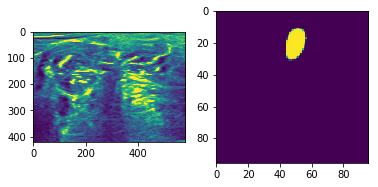

In [36]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
import os
%matplotlib inline

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.asarray(Image.open(os.environ['DATASET_DIR']+os.sep+'test/100.tif', 'r')))
axarr[1].imshow(np.asarray(Image.open(os.environ['TRAINING_DIR']+os.sep+'100_pred.png', 'r')))

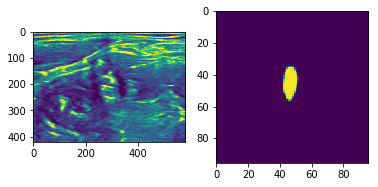

In [37]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.asarray(Image.open(os.environ['DATASET_DIR']+os.sep+'test/200.tif', 'r')))
axarr[1].imshow(np.asarray(Image.open(os.environ['TRAINING_DIR']+os.sep+'200_pred.png', 'r')))

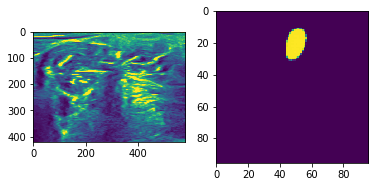

In [38]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.asarray(Image.open(os.environ['DATASET_DIR']+os.sep+'test/300.tif', 'r')))
axarr[1].imshow(np.asarray(Image.open(os.environ['TRAINING_DIR']+os.sep+'_pred.png', 'r')))

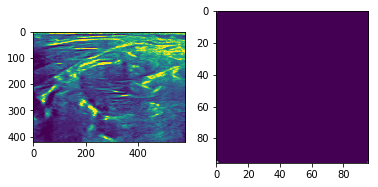

In [39]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.asarray(Image.open(os.environ['DATASET_DIR']+os.sep+'test/1.tif', 'r')))
axarr[1].imshow(np.asarray(Image.open(os.environ['TRAINING_DIR']+os.sep+'1_pred.png', 'r')))

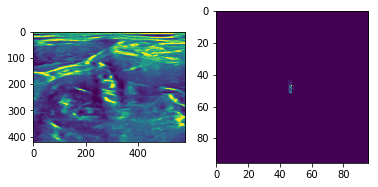

In [40]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.asarray(Image.open(os.environ['DATASET_DIR']+os.sep+'test/1.tif', 'r')))
axarr[1].imshow(np.asarray(Image.open(os.environ['TRAINING_DIR']+os.sep+'1_pred.png', 'r')))